In [27]:
import pytesseract
from pytesseract import Output
import re
import glob
import numpy as np
import cv2
from PIL import Image #testando
import imutils #testando
from collections import namedtuple #testando
from skimage import filters
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7) #apresenta todas as imagens na proporção definida

### Função que lê imagens, aplica image_to_data e retorna as keys

In [28]:
def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

### Desenha boxes usando o retorno do image_to_data

In [144]:
def drawboxes(img, d):
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #if int(d['conf'][i]) > 40:
        if int(d['left'][i]) > 60 and int(d['top'][i]) > 95:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img

### Limpa texto

In [74]:
#limpa caracteres não ASCII
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

## Funções usando image_to_data

In [196]:
def get_datas(img, d):
    #date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$' # expressão regular para datas
    date_pattern = '(\d+/\d+/\d+)'
    data_nasc, data_val, data_ph = 0, 0, 0
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40 and int(d['left'][i]) > 80 and int(d['top'][i]) > 80:
            #print(d['text'][i])
            if re.match(date_pattern, d['text'][i]):
                #print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                if int(d['top'][i]) >= 90 and int(d['top'][i]) <= 140:
                    data_nasc = d['text'][i]
                elif int(d['left'][i]) >= 210 and int(d['left'][i]) <= 250:
                    data_val = d['text'][i]
                elif int(d['left'][i]) >= 350 and int(d['left'][i]) <= 500:
                    data_ph = d['text'][i]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return data_nasc, data_val, data_ph

In [111]:
def get_cpf(img, d):
    #cpf_pattern = '[0-9]{3}\.?[0-9]{3}\.?[0-9]{3}\-?[0-9]{2}'

    cpf_expr = re.compile('\d{3}\.\d{3}\.\d{3}\-\d{2}')                   

    cpf = 0
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40:
            if re.match(cpf_expr, d['text'][i]):
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cpf = d['text'][i]
                
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
    
    return cpf

## Funções usando image_to_string 
Obs.: Todos os pontos usados para delimitar as áreas de interesse estão de acordo com as imagens processadas. Mudar se for usar nas alinhadas ou em outro padrão de imagens

In [105]:
def get_name_roi(img):
    
    imgcrop = img[5:5+45, 5:5+490] # para as alinhadas: img[100:100+40, 90:90+490]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    #print(text)
    name = cleanup_text(text)
    name = re.findall('[A-Z]+', name)
    nomecomp = ""
    for n in name:
        nomecomp += f" {n}"
    
    return nomecomp

In [129]:
def get_cpf_roi(img):
    
    imgcrop = img[100:100+30, 220:220+160]
    text = pytesseract.image_to_string(imgcrop, lang='por')

    return text

In [142]:
def get_nreg_roi(img):
    
    imgcrop = img[295:295+40, 20:20+160]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    num = re.findall('[0-9]+', text)
    numreg = ""
    
    for n in num:
        numreg += f" {n}"
    
    return numreg

In [158]:
def get_rg_roi(img):
    
    imgcrop = img[60:60+25, 210:210+100]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    num = re.findall('[0-9]+', text)
    ng = ""
    
    for n in num:
        ng += f" {n}"
    
    return ng

In [180]:
# !verificar
def get_datanasc_roi(img):
    
    imgcrop = img[100:100+30, 370:370+135]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    data = re.findall('^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$', text)
    
    return data

In [198]:
def get_dataval_roi(img):
    
    imgcrop = img[290:290+50, 210:210+125]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    data = re.findall('\d+/\d+/\d+', text)
    
    return data

# Chamada das funções

In [199]:
imgs = glob.glob("../processadas/*jpg")

for c in imgs:
    
    img = cv2.imread(c)
    name = get_name_roi(img)
    #print(name)
    
    cpf = get_cpf_roi(img)
    #print(cpf)
    
    nreg = get_nreg_roi(img)
    #print(nreg)
    
    rg = get_rg_roi(img)
    #print(rg)
    
    datanasc = get_datanasc_roi(img)
    #print(datanasc)
    
    dataval = get_dataval_roi(img)
    print(dataval)
    
#     plt.imshow(cv2.cvtColor(dataval, cv2.COLOR_BGR2RGB))
#     plt.show()

['23/02/2023']
['04/03/2021']
[]
['02/05/2021']
['06/03/2025']
['23/02/2023']
[]


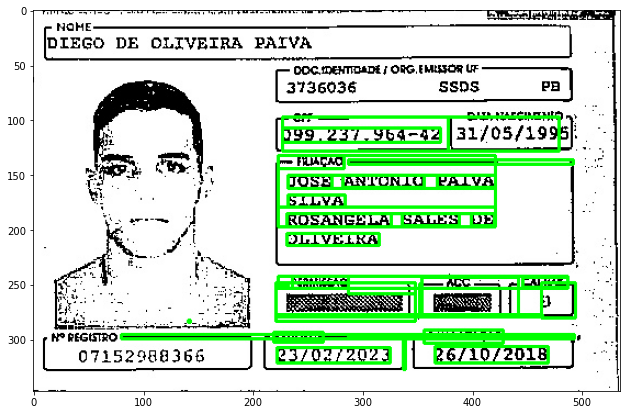

CPF:  0
Data de nascimento:  0
Data de validade:  23/02/2023
Data da 1° habilitação:  26/10/2018


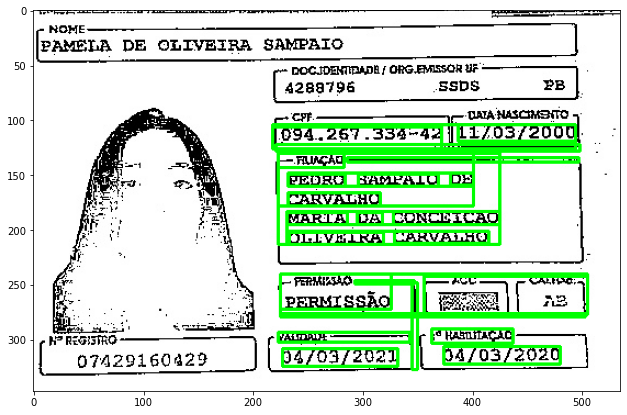

CPF:  0
Data de nascimento:  11/03/2000
Data de validade:  04/03/2021
Data da 1° habilitação:  04/03/2020


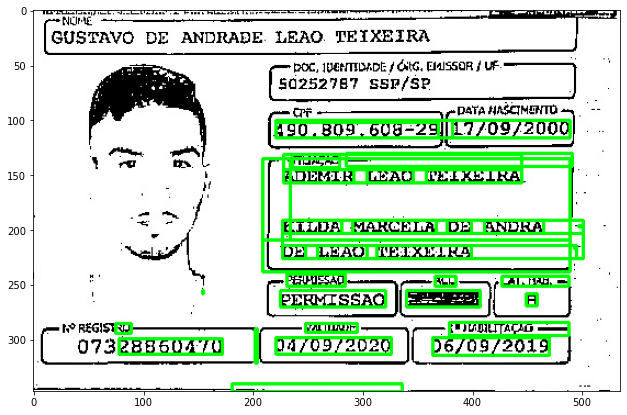

CPF:  450.809.605-29
Data de nascimento:  17/09/2000
Data de validade:  04/09/2020
Data da 1° habilitação:  06/05/2019


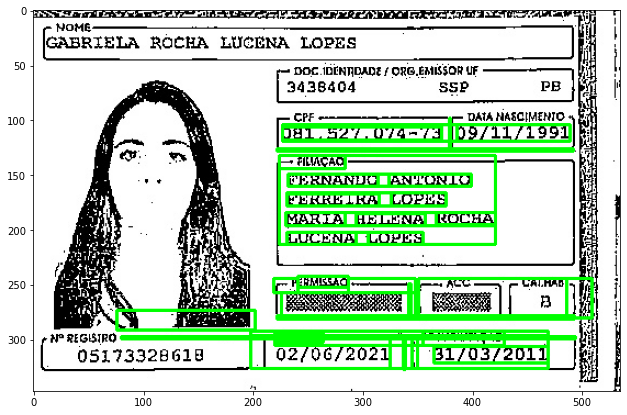

CPF:  0
Data de nascimento:  09/11/1991
Data de validade:  0
Data da 1° habilitação:  31/03/2011


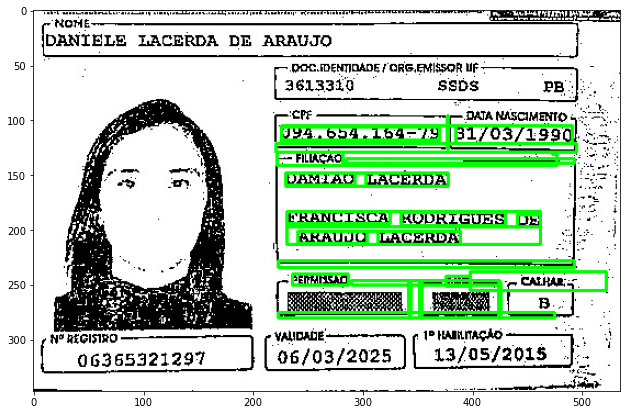

CPF:  0
Data de nascimento:  31/03/1990
Data de validade:  0
Data da 1° habilitação:  0


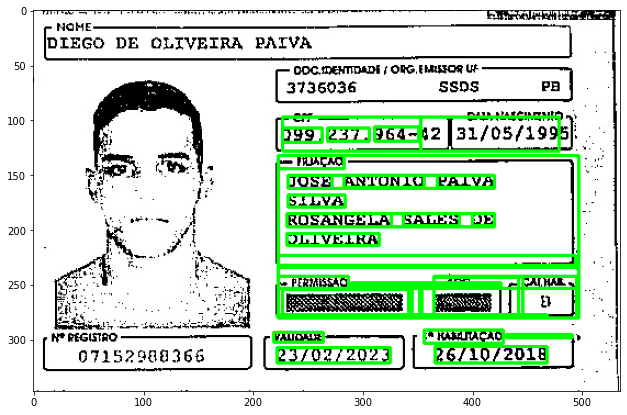

CPF:  0
Data de nascimento:  0
Data de validade:  23/02/2023
Data da 1° habilitação:  26/10/2018


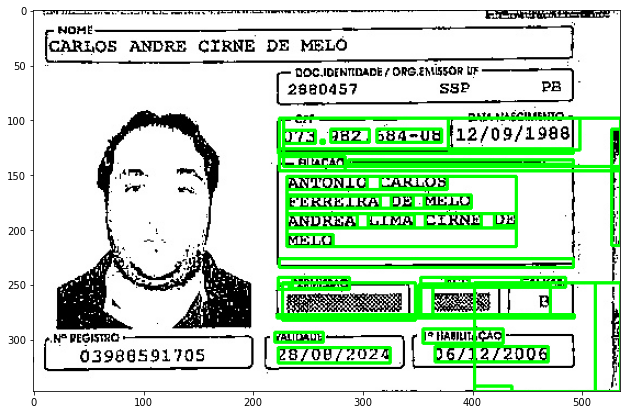

CPF:  0
Data de nascimento:  0
Data de validade:  28/08/2024
Data da 1° habilitação:  06/12/2006


In [197]:
imgs = glob.glob("../processadas/*jpg")

for j in imgs:
    img = cv2.imread(j)
    
    d = data_keys(img)
    img = drawboxes(img, d)
    
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
    data_nasc, data_val, data_ph = get_datas(img, d)
    cpf = get_cpf(img, d)
    print("CPF: ", cpf)
    print("Data de nascimento: ", data_nasc)
    print("Data de validade: ", data_val)
    print("Data da 1° habilitação: ", data_ph)

Próximos passos:

- melhorar segmentação das imagens, a leitura está péssima

-validar o cpf
https://community.alteryx.com/t5/Casos-de-uso-Portugues/Validacao-de-CPF-com-digito-verificador/ta-p/437296

OBS.: o regex cpf_pattern está reconhecendo o número de registro e não o cpf